In [112]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [114]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [115]:
columns = ['Tweet_ID', 'Entity', 'Sentiment', 'Message']

df_train = pd.read_csv('/content/twitter_training.csv', names=columns)
df_validate = pd.read_csv('/content/twitter_validation.csv', names=columns)

In [116]:
df_train.head()

,Tweet_ID,Entity,Sentiment,Message
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [117]:
df_validate.head()

,Tweet_ID,Entity,Sentiment,Message
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [118]:
df_train.shape

(74682, 4)

In [119]:
df_validate.shape

(1000, 4)

In [120]:
df_train.isna().sum()

,0
Tweet_ID,0
Entity,0
Sentiment,0
Message,686


In [121]:
df_train.dropna(inplace=True)

In [122]:
df_train.isna().sum()

,0
Tweet_ID,0
Entity,0
Sentiment,0
Message,0


In [123]:
df_train.duplicated().sum()

2340

In [124]:
df_train.drop_duplicates(inplace=True)

In [125]:
df_train.duplicated().sum()

0

In [126]:
df_train.shape

(71656, 4)

In [127]:
#Distribution of the Sentiment Column
sentiment_count = df_train['Sentiment'].value_counts()
sentiment_count

,count
Sentiment,
Negative,21698
Positive,19713
Neutral,17708
Irrelevant,12537


In [128]:
sentiment_count_validate = df_validate['Sentiment'].value_counts()
sentiment_count_validate

,count
Sentiment,
Neutral,285
Positive,277
Negative,266
Irrelevant,172


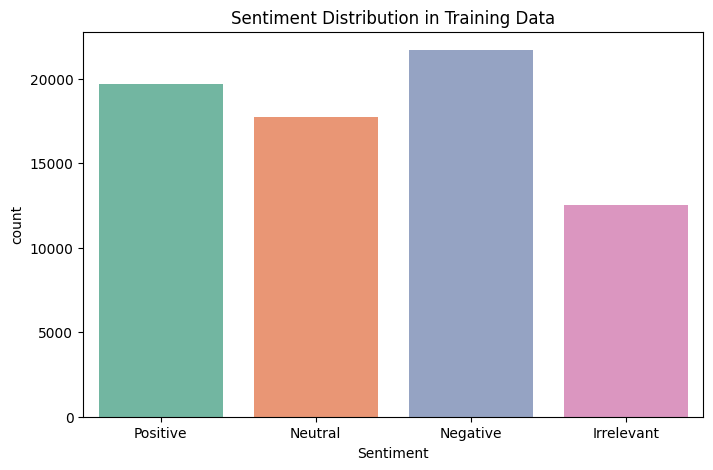

In [129]:
plt.figure(figsize=(8,5))
sns.countplot(x='Sentiment', data=df_train, hue='Sentiment', palette='Set2')
plt.title('Sentiment Distribution in Training Data')
plt.show()

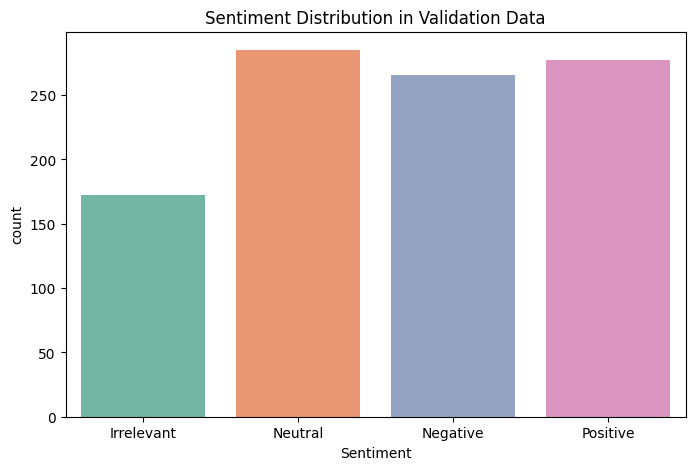

In [130]:
#For validate Dataset
plt.figure(figsize=(8,5))
sns.countplot(x='Sentiment', data=df_validate, hue='Sentiment', palette='Set2')
plt.title('Sentiment Distribution in Validation Data')
plt.show()

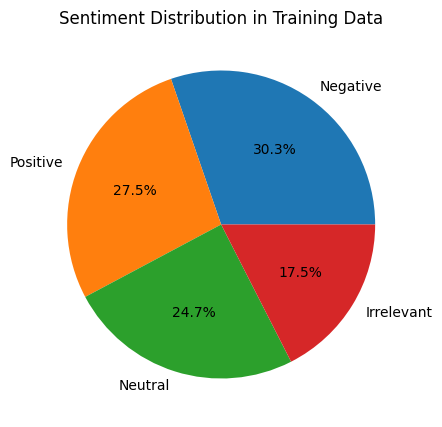

In [131]:
plt.figure(figsize=(8,5))
plt.pie(sentiment_count, labels=sentiment_count.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution in Training Data')
plt.show()

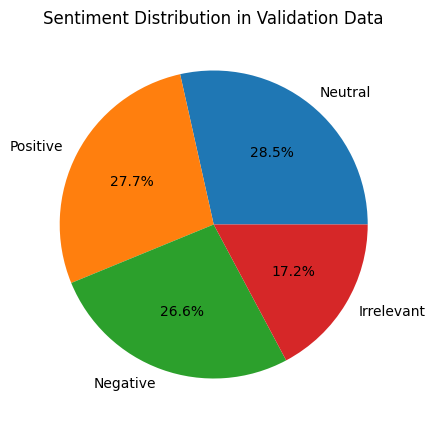

In [132]:
plt.figure(figsize=(8,5))
plt.pie(sentiment_count_validate , labels=sentiment_count_validate .index, autopct='%1.1f%%')
plt.title('Sentiment Distribution in Validation Data')
plt.show()

In [133]:
group = df_train.groupby('Entity')['Sentiment'].value_counts()

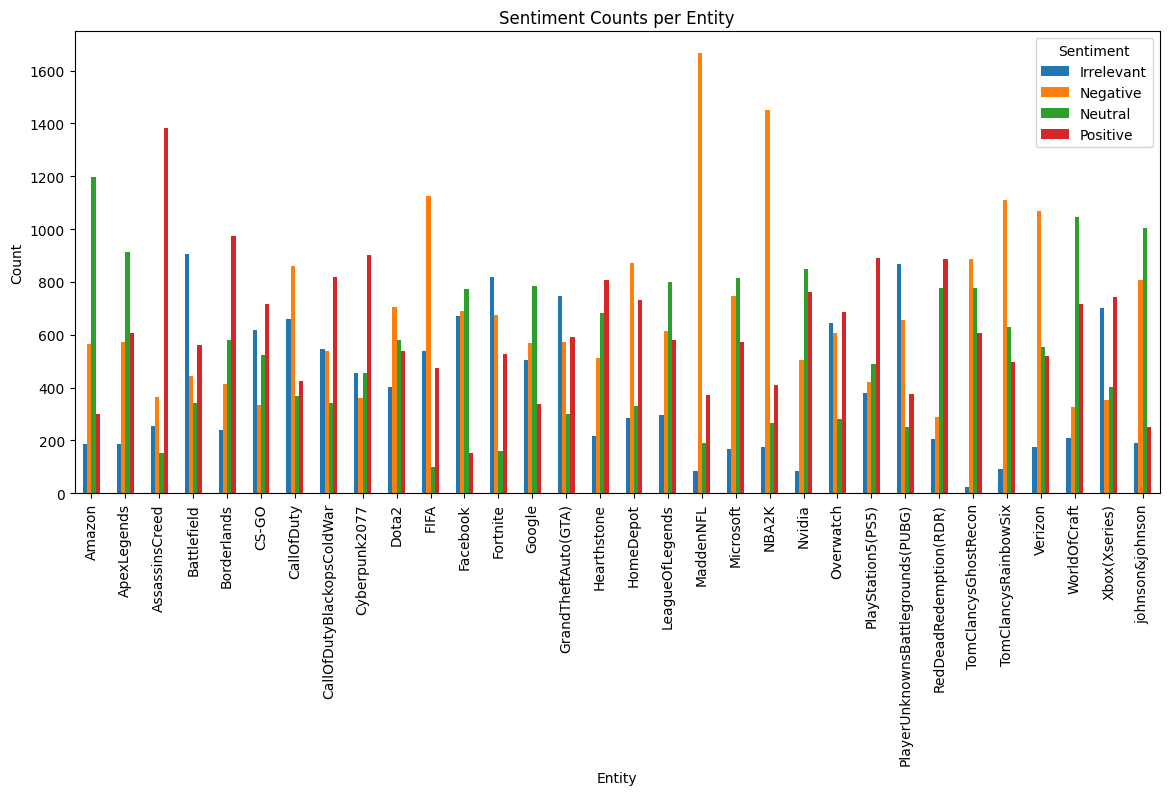

In [134]:
group.unstack().plot(kind='bar', figsize=(14,6))
plt.title('Sentiment Counts per Entity')
plt.ylabel('Count')
plt.xlabel('Entity')
plt.legend(title='Sentiment')
plt.show()

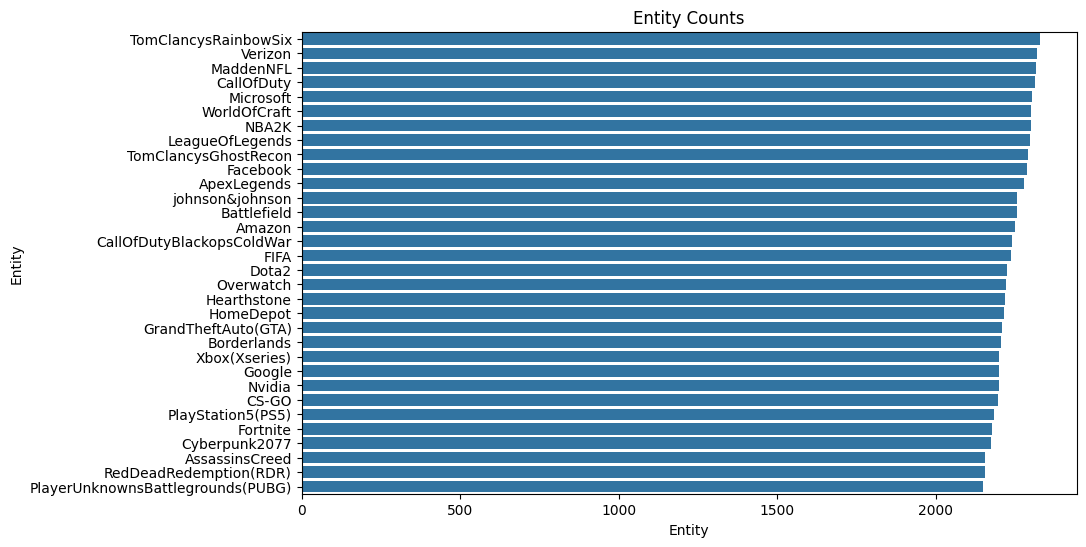

In [135]:
#Entity Count
entity_counts = df_train['Entity'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=entity_counts.values, y=entity_counts.index)
plt.title('Entity Counts')
plt.xlabel('Entity')
plt.show()

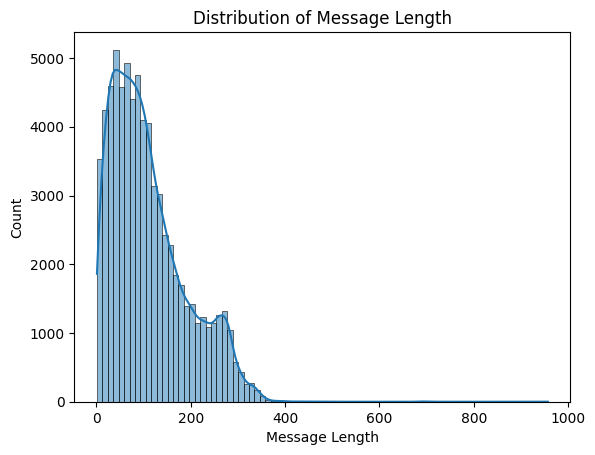

In [136]:
message_length = df_train['Message'].apply(len)
sns.histplot(message_length, kde=True, bins=83) #Bins using Rice's Rule
plt.title('Distribution of Message Length')
plt.xlabel('Message Length')
plt.show()

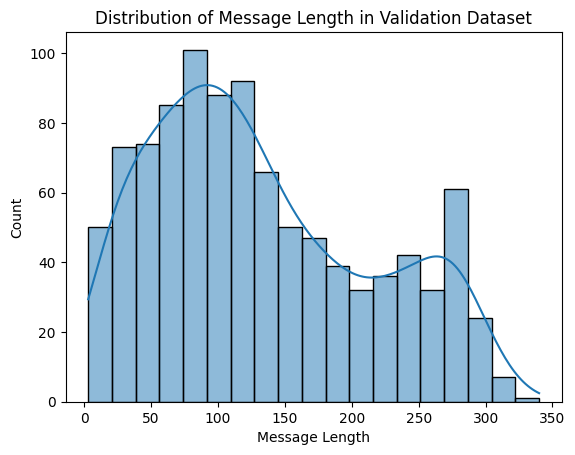

In [137]:
message_length_validate = df_validate['Message'].apply(len)
sns.histplot(message_length_validate, kde=True, bins=19) #Bins using Rice's Rule
plt.title('Distribution of Message Length in Validation Dataset')
plt.xlabel('Message Length')
plt.show()

**Stemming**

In [138]:
port_stem = PorterStemmer()

In [139]:
stop_words = set(stopwords.words('english')).union({'u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'}) - {'about', 'you', 'out'}
def stemming(text):
    text = text.lower()# Lowercase the text
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)# Remove URLs
    text = re.sub(r'@\w+', '', text)# Remove mentions
    text = ''.join([char for char in text if char not in string.punctuation])# Remove punctuation
    text = ''.join([char for char in text if not char.isdigit()])# Remove digits
    text = ' '.join([port_stem.stem(word) for word in text.split() if word not in stop_words])# Remove stopwords

    return text

In [140]:
df_train['Stemmed_content'] = df_train['Message'].apply(stemming)

In [141]:
df_train.sample(10)

,Tweet_ID,Entity,Sentiment,Message,Stemmed_content
63348,7658,MaddenNFL,Irrelevant,If I had online.,onlin
19615,12558,WorldOfCraft,Positive,"We got the wobbly metaplate! Great job, team!",got wobbl metapl great job team
32823,6433,Fortnite,Neutral,i won in fortnite by doing nothing.... well th...,fortnit noth well hurt
1116,2597,Borderlands,Positive,Borderlands 3 is Amazing twitch.tv/nightshade1...,borderland amaz twitchtvnightshad
34993,8012,Microsoft,Positive,Extremely important news this year,extrem import news year
42804,10143,PlayerUnknownsBattlegrounds(PUBG),Negative,This is bliss!,bliss
18678,12402,WorldOfCraft,Positive,ESL Pro Tour | StarCraft II & Warcraft III Oh ...,esl pro tour starcraft ii warcraft iii oh god ...
59116,3333,Facebook,Irrelevant,... Creepy geek not only an intellectual prope...,creepi geek intellectu properti rich thief pos...
39910,1251,Battlefield,Irrelevant,A ban for Battlefield Legends 4 DVD player fee...,ban battlefield legend dvd player feenalslick ...
43469,10261,PlayerUnknownsBattlegrounds(PUBG),Irrelevant,@soulregaltos my best there player Don't keep ...,best player keep sad lost anoth door open best...


In [142]:
le = LabelEncoder()
df_train['Sentiment'] = le.fit_transform(df_train['Sentiment'])
df_train.sample(10)

,Tweet_ID,Entity,Sentiment,Message,Stemmed_content
7024,9208,Overwatch,1,and RhandlerR I WAIT 15MIN FOR GAMES AND GET T...,rhandlerr wait min game get error way much plz...
66664,7015,johnson&johnson,1,"Oh but look, same people who make your preciou...",oh look peopl make preciou babi powder also ma...
33522,6559,Fortnite,0,Honestly... that mentality is disgusting and a...,honestli mental disgust almost destroy soooo m...
18923,12442,WorldOfCraft,2,I just watched the Year of the Curve: N'Zoth t...,watch year curv nzoth corruptor achiev
4944,50,Amazon,2,. . TAGLIA: 28. PREZZO: 125 EURO ift.tt/31Mik...,taglia prezzo euro iftttmiksr
51115,6374,FIFA,0,if that happens gg you are one of the funniest...,happen gg you one funniest fifa youtub
15503,3052,Dota2,1,I eat egg and i hate dota 2 - Casey,eat egg hate dota casey
26813,1007,AssassinsCreed,3,So bad ass. The Hype is real in my ears. I'm c...,bad ass hype real ear count movi releas
1239,2617,Borderlands,0,Man ic shit on Borderlands 2 (and 1 especially...,man ic shit borderland especi mostli borderlan...
43232,10220,PlayerUnknownsBattlegrounds(PUBG),0,@ ZakaWaqar. You made it! You made it possible...,zakawaqar you made you made possibl thank you ...


**1** -> Negative :	21698

**3** -> Positive :	19713

**2** -> Neutral :	17708

**0** -> Irrelevant :	12537

In [143]:
X = df_train['Stemmed_content'].values
y = df_train['Sentiment'].values

In [144]:
X

array(['get borderland murder you', 'come border kill you',
       'get borderland kill you', ...,
       'realiz window partit mac year behind nvidia driver idea didn’t notic',
       'realiz window partit mac like year behind nvidia driver car fuck idea ever ’ notic',
       'like window partit mac like year behind driver you idea didn’t notic'],
      dtype=object)

In [145]:
y

array([3, 3, 3, ..., 3, 3, 3])

In [146]:
#split into train test
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=2)

In [147]:
print(X.shape, X_train.shape, X_test.shape)

(71656,) (57324,) (14332,)


In [148]:
X_train

array(['look forward actual', 'everyth about book sound good',
       'ban battlefield player wolfman hd yt occur see detail bfdbcom player ban',
       ...,
       'edg chromium good news japanes privaci consciou technolog folk built up privaci control technolog eventu give microsoft industri edg googl find out retaildirect co uk blog microsoft …',
       'still want know riot rank tft mission leagu legend mission damn annoy',
       'peopl job verizon phone work'], dtype=object)

In [149]:
y_train

array([3, 0, 0, ..., 3, 1, 1])

In [150]:
unique_values, counts = np.unique(y_train, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 10114
1: 17307
2: 14111
3: 15792


In [151]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [152]:
print(X_train)

  (0, 13475)	0.46977498808341384
  (0, 8281)	0.6834695948279818
  (0, 188)	0.5587313965734366
  (1, 7257)	0.4671560364797254
  (1, 67)	0.3395435809638721
  (1, 2744)	0.5486098586114885
  (1, 22116)	0.500342504893272
  (1, 9363)	0.33935231697778717
  (2, 1754)	0.39799014934976523
  (2, 1858)	0.20522744741931445
  (2, 18324)	0.37667678123938914
  (2, 26926)	0.44223643144708064
  (2, 10098)	0.3310436064656973
  (2, 27924)	0.3498339983648546
  (2, 16116)	0.24933325556491312
  (2, 21036)	0.1707289202251673
  (2, 5678)	0.23569700634367247
  (2, 2170)	0.28841786681378373
  (3, 13475)	0.3965777225894669
  (3, 27138)	0.5224693201539267
  (3, 21647)	0.7548191302846302
  (4, 1858)	0.17743822591592698
  (4, 25480)	0.3643660910493199
  (4, 796)	0.31219216358471713
  (4, 25627)	0.1669607090400272
  :	:
  (57321, 7237)	0.17904084720357005
  (57321, 2564)	0.175143088166609
  (57321, 6686)	0.3431078785855896
  (57321, 25534)	0.18699533193255025
  (57321, 4565)	0.2431857703152253
  (57321, 11884)	0.2001

In [153]:
print(X_test)

  (0, 2779)	0.14979956510498582
  (0, 3812)	0.25543523907165944
  (0, 4490)	0.20210505212122096
  (0, 4845)	0.1822556358845446
  (0, 4994)	0.15626730743516312
  (0, 5092)	0.1757998674775842
  (0, 5282)	0.25083276574776847
  (0, 6605)	0.23328323272992915
  (0, 7012)	0.18983275509221884
  (0, 7231)	0.268577208681831
  (0, 10383)	0.19165664891526482
  (0, 12850)	0.22230408237550317
  (0, 12911)	0.1805061912614499
  (0, 14553)	0.19776584843783318
  (0, 14823)	0.1822556358845446
  (0, 19561)	0.1756619597167367
  (0, 20540)	0.16752319177725622
  (0, 21175)	0.18140977259580895
  (0, 23852)	0.26754120153596783
  (0, 24356)	0.14334620772698792
  (0, 26146)	0.26087880962519044
  (0, 26301)	0.16544930828032056
  (0, 26321)	0.2948988729721571
  (1, 9363)	0.2404761988620441
  (1, 10141)	0.40984804205465053
  :	:
  (14329, 7318)	0.14861456679025414
  (14329, 8449)	0.22884998098886655
  (14329, 8588)	0.1426610339068616
  (14329, 12105)	0.17800973433724113
  (14329, 15632)	0.3024415590341039
  (14329,

In [154]:
model = LogisticRegression(max_iter = 1000)

In [155]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

**Evaluating the Model**

In [156]:
#Accuracy score on the training dataset
train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)

In [157]:
print("Accuracy Score on the Training Data :",train_accuracy )

Accuracy Score on the Training Data : 0.8094689833228665


In [158]:
#Accuracy score on the Test dataset
test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)

In [159]:
print("Accuracy Score on the Test Data :",test_accuracy )


Accuracy Score on the Test Data : 0.7348590566564331


In [160]:
X_new = X_test[280:285]
print(f'Original Sentiment : {y_test[280:285]}')

Original Sentiment : [3 1 1 2 1]


In [161]:
predictons = model.predict(X_new)

In [162]:
def sentiment_label(value):
    if value == 0:
        return "Irrelevant"
    elif value == 1:
        return "Negative"
    elif value == 2:
        return "Neutral"
    else:
        return "Positive"
for predicton in predictons:
  print(f'Predicted Sentiment : {sentiment_label(predicton)}')

Predicted Sentiment : Positive
Predicted Sentiment : Negative
Predicted Sentiment : Negative
Predicted Sentiment : Neutral
Predicted Sentiment : Negative


**Evaluation of Model on Validation Dataset**

In [163]:
df_validate['Stemmed_content'] = df_validate['Message'].apply(stemming)
df_validate.sample(10)

,Tweet_ID,Entity,Sentiment,Message,Stemmed_content
859,3590,Facebook,Irrelevant,@SpeakerPelosi this is VERY INTERESTING 🧐,interest 🧐
232,3037,Dota2,Neutral,die with honor stfu and press ur bkb,die honor stfu press bkb
921,5068,GrandTheftAuto(GTA),Positive,I wanna do this shit,wanna shit
706,8728,NBA2K,Negative,I’m done bro all my stuff got corrupt and I’m ...,i’m done bro stuff got corrupt i’m download ga...
326,8373,Microsoft,Neutral,"I may not be the first to observe this, but Ma...",may first observ maco develop make internet go...
176,4697,Google,Irrelevant,Google your name + horror + aesthetic.\nI don...,googl name horror aesthet exist enough use mid...
495,8055,Microsoft,Positive,special shoutouts to microsoft excel 2013,special shoutout microsoft excel
596,6102,FIFA,Irrelevant,Super Eagles move up four places in February F...,super eagl move four place februari fifa rank ...
953,3639,Cyberpunk2077,Neutral,#Cyberpunk2077 has been delayed again!\nTo pas...,cyberpunk delay pass time grab excit cyberpunk...
579,2695,Borderlands,Positive,I wanna play Shooty McLootyguns with more peop...,wanna play shooti mclootygun peopl borderland ...


In [164]:
X_validate = df_validate['Stemmed_content'].values
df_validate['Sentiment'] = le.fit_transform(df_validate['Sentiment'])
validation_labels = df_validate['Sentiment'].values

In [165]:
X_train_vectorized = vectorizer.transform(X_validate)

In [166]:
validate_pred = model.predict(X_train_vectorized)

In [167]:
val_accuracy = accuracy_score(validation_labels, validate_pred)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.855
